In [1]:
import sys
import datetime as dt
from copy import deepcopy
from os import getcwd
from os.path import dirname, join

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from scipy import interpolate
import pytz

PROJ_DIR = dirname(getcwd())
sys.path.append(PROJ_DIR)

SRC_DIR = join(PROJ_DIR, 'MAMMAL')
DATA_DIR = join(PROJ_DIR, 'data')
TEST_DIR = join(DATA_DIR, 'test')

import MAMMAL
import MAMMAL.Diurnal as Diurnal
from MAMMAL.Parse import parseIM as pim
from MAMMAL.Parse import parseRaster as pr
from MAMMAL.Utils import mapUtils as mu
from MAMMAL.Utils import ProcessingUtils as pu


%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10) # (w, h)
pd.set_option('mode.chained_assignment', None)


SURVEY_NAME  = 'NC-VA_3075'
SURVEY_FNAME = 'NC_3075_rad.xyz'
SURVEY_PATH  = join(join(TEST_DIR, SURVEY_NAME), SURVEY_FNAME)

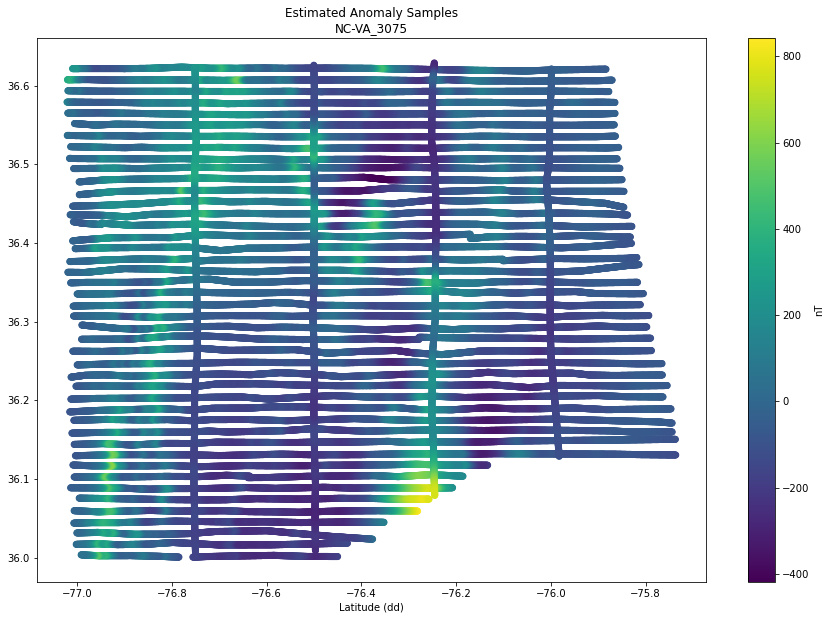

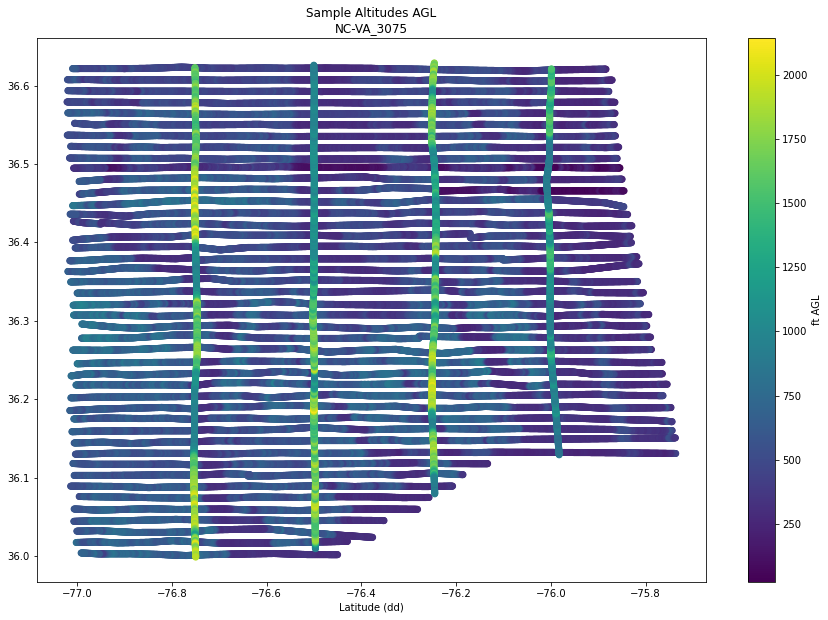

In [2]:
df = pd.read_csv(SURVEY_PATH,
                 delim_whitespace=True,
                 na_values=-9999.9,
                 names=['line',
                        'fiducial',
                        'day',
                        'year',
                        'latitude',
                        'longitude',
                        'radalt',
                        'totmag' ,
                        'resmag',
                        'total_count'])

plt.figure()
plt.title('Estimated Anomaly Samples\n{}'.format(SURVEY_NAME))
plt.scatter(df.longitude, df.latitude, c=df.resmag)
plt.xlabel('Longitude (dd)')
plt.xlabel('Latitude (dd)')
plt.colorbar(label='nT')

plt.figure()
plt.title('Sample Altitudes AGL\n{}'.format(SURVEY_NAME))
plt.scatter(df.longitude, df.latitude, c=df.radalt)
plt.xlabel('Longitude (dd)')
plt.xlabel('Latitude (dd)')
plt.colorbar(label='ft AGL')

In [3]:
df = df.dropna()

mammal_df = deepcopy(df)
mammal_df.rename(columns={'resmag':    'F',
                          'latitude':  'LAT',
                          'longitude': 'LONG',
                          'line':      'LINE'},
                 inplace=True)

mammal_df['ALT']       = 2000
mammal_df['LINE_TYPE'] = 0
mammal_df.LINE_TYPE[mammal_df.LINE < 100]  = 1
mammal_df.LINE_TYPE[mammal_df.LINE >= 100] = 2

Interpolating survey anomaly data to map coordinates
Running radial basis function (RBF) interpolation for all map pixels
NaN'ing-out pixes that are at least min(h AGL)/2 dist away from all sample locations


100%|██████████| 31740/31740 [00:36<00:00, 869.54it/s]


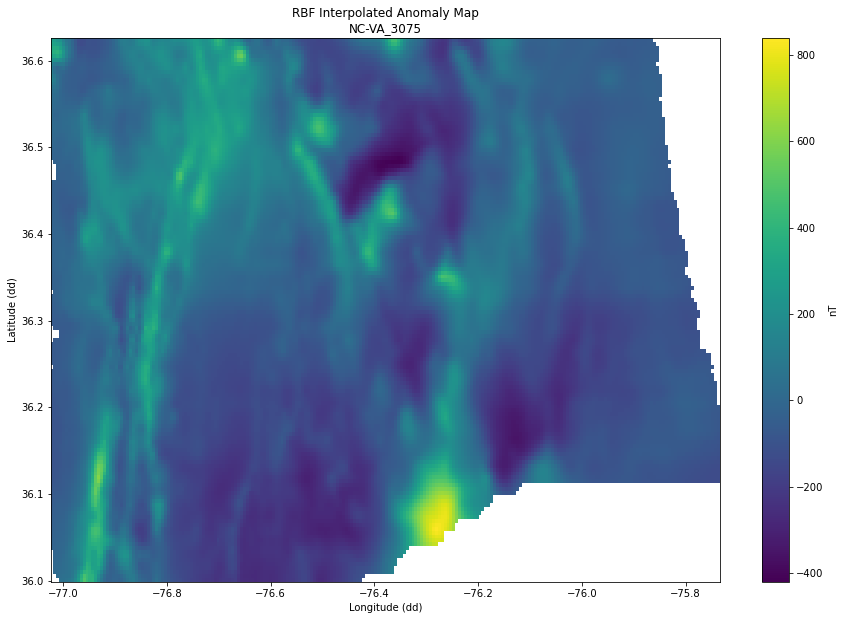

In [4]:
interp_dict = pu.interp_flight_lines(anomaly_df      = mammal_df,
                                     dx              = 500,
                                     dy              = 500,
                                     max_terrain_msl = 0,
                                     interp_type='rbf')

plt.figure()
plt.title('RBF Interpolated Anomaly Map\n{}'.format(SURVEY_NAME))
plt.pcolormesh(interp_dict['LONG'], interp_dict['LAT'], interp_dict['F'])
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.colorbar(label='nT')